<a href="https://colab.research.google.com/github/angel870326/Monthly-Revenue-Forecasting/blob/main/025_rnn_lstm_search_mean_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 2023.06.12 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

# **Monthly Revenue Forecasting with RNN & LSTM (Variables: + Search Volume) - Results (2018-2022)**

|Search Volume     |Variables     |
|------------------|--------------|
|Mean of t-4 to t-1|t_sv          |

<br>

### Contents

##### 1. Input Data
*  月營收盈餘 (2013-2022)
*  網路聲量 (2013-2022)：t-4 到 t-1 的平均 (*new)

##### 5. Model Training
*  預先訓練多個模型並儲存
*  Training History

##### 7. Predicting Results & Feature Importance
*  Output Functions
*  RNN
*  LSTM
*  Scores (RMSE, MAPE, MAE, MAE%)

##### 8. Plots
*  Read Saved Results (*new)
*  Expected v.s. Predicted
*  Scores: RMSE, MAPE, MAE, MAE%

##### 9. Best and Worst Model
*  各模型組合中，預測最好和最差的月份
*  RNN 和 LSTM 各自預測最好和最差的模型組合
*  所有模型組合中，預測最好和最差的模型組合






## **0. Setup**

In [ ]:
# sConnect to the Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
!pip install import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.7 MB/s eta 0:00:00


In [ ]:
import import_ipynb
%cd '/content/gdrive/Shareddrives/Me/論文/code/Function'

/content/gdrive/MyDrive/論文/code/Function


In [ ]:
from MonRevForecast import predictMonthlyRevenueNN, BestWorstModelNN, trainMonthlyRevenueNN

importing Jupyter notebook from MonRevForecast.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.6 MB/s eta 0:00:00


In [ ]:
from MonRevPlot import plotExpectedPredictedRevenues, plotModelExpectedPredictedRevenues

importing Jupyter notebook from MonRevPlot.ipynb


In [ ]:
from MonRevPlot import plotAllScores, compareModelScore, scoreBoxplotV

In [ ]:
from MonRevForecast import plotTrainingHistory

### **Project Path**

In [ ]:
project_path = '/content/gdrive/Shareddrives/Me/論文'

## **1. Input Data**

### **1.1 月營收盈餘 (2013-2022)**

資料期間：2013年1月至2022年12月（共120個月）

資料範圍：上市、櫃公司（排除金融業、生技醫療、建材營造、DR和KY公司）

資料來源：TEJ Company DB、公開資訊觀測站

In [ ]:
org_data = pd.read_excel(os.path.join(project_path, '資料集/007_v1/201301-202212上市櫃公司月營收_非金融業.xlsx'), index_col=0)
org_data.columns = pd.to_datetime(org_data.columns, format="%Y-%m-%d").to_period('M')
org_data

2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  2013-07  \
公司                                                                        
1101 台泥   9134465  5540346  9457971  9919269  9543782  9517630  9875888   
1102 亞泥   6018213  2552357  5428755  5930748  6239676  5952754  5942364   
1103 嘉泥    288455   166638   286007   365292   382601   302995   294781   
1104 環泥    486481   299860   461732   394631   406677   415968   453397   
1108 幸福    481802   276936   444917   362054   381384   368109   439572   
...           ...      ...      ...      ...      ...      ...      ...   
9951 皇田    201785   167967   240746   243935   238296   193880   198427   
9955 佳龍    394489   383183   428478   564053   336622   295391   434605   
9958 世紀鋼   198944   166364   351222   280864   289332   426371   213281   
9960 邁達康    52534    41935    61642    70998    81508    64525    62085   
9962 有益    298876   327002   313861   241566   251782   273664   174682   

          2013-08   2013-09   2013-10  ...  2022-03  2022-04  2022-05  \
公司                                     ...                              
1101 台泥   9835143  10060975  10654077  ...  9971650  8319342  7733787   
1102 亞泥   5786107   5879394   6478670  ...  8160414  8710220  8000427   
1103 嘉泥    336088    314563    429783  ...   220463   168089   163521   
1104 環泥    393203    448691    521445  ...   591593   638493   537082   
1108 幸福    379115    387362    450770  ...   345612   335518   332258   
...           ...       ...       ...  ...      ...      ...      ...   
9951 皇田    256724    228796    250756  ...   374229   302262   323433   
9955 佳龍    306534    266617    363766  ...    96200   101850    95096   
9958 世紀鋼   302589    401695    255738  ...   626104   401960   673479   
9960 邁達康    60960     60309     61582  ...    60275    86754    69752   
9962 有益    238490    165340    202491  ...   366892   248958   228412   

          2022-06   2022-07   2022-08   2022-09   2022-10  2022-11   2022-12  
公司                                                                            
1101 台泥   9145989  10102468  10689860  10404901  11368096  9674576  12584154  
1102 亞泥   7776413   7864622   7069221   6994078   7601097  8306062   8340507  
1103 嘉泥    183177    178825    182371    205264    209429   221763    228644  
1104 環泥    573028    580420    605512    597159    634981   631827    725055  
1108 幸福    334113    326691    390053    346635    401202   383773    418326  
...           ...       ...       ...       ...       ...      ...       ...  
9951 皇田    371791    337581    468608    464373    432835   500111    506796  
9955 佳龍     80726     85625     81881     79179     80630    91270     84115  
9958 世紀鋼   665459    651699    757968    903198    911834   944060   1082675  
9960 邁達康   103280     64983    105969    113755     78996    96570     58764  
9962 有益    387082    248327    318092    264270    307426   308663    385673  

[1240 rows x 120 columns]

In [ ]:
print("Data shape:", org_data.shape)
print("Data size:", org_data.size)

Data shape: (1240, 120)
Data size: 148800


### **1.2 網路聲量 (2013-2022)：t-4 到 t-1 的平均**

In [ ]:
search_volume_data = pd.read_csv(os.path.join(project_path, '資料集/search volume/search_volume_mean.csv'), index_col = 0)
search_volume_data.columns = pd.to_datetime(search_volume_data.columns, format="%Y-%m-%d").to_period('M')
search_volume_data

2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  2013-07  \
1101 台泥      42.0    42.50     0.00    25.00    25.50    13.00    25.00   
1102 亞泥      34.5     0.00    27.50    20.75    20.50    27.75    13.75   
1103 嘉泥       0.0    14.50    21.00    31.75     0.00    15.00     8.00   
1104 環泥      25.0     0.00    40.00     0.00     0.00    36.25     0.00   
1108 幸福      64.5    59.00    76.50    75.00    65.75    66.25    77.50   
...           ...      ...      ...      ...      ...      ...      ...   
9951 皇田       0.0    14.00    12.50     8.25     4.50     0.00    13.00   
9955 佳龍      25.5     7.25    25.00    13.50    29.75    23.75    53.00   
9958 世紀鋼     25.0     0.00    24.25     6.25    36.25     0.00     0.00   
9960 邁達康     25.0     0.00    52.50     0.00    34.75     0.00    25.50   
9962 有益       0.0    16.75     0.00    15.50    31.50     0.00    23.25   

          2013-08  2013-09  2013-10  ...  2022-03  2022-04  2022-05  2022-06  \
1101 台泥      0.00     8.00    10.50  ...    40.00    36.00    62.00    41.75   
1102 亞泥     22.50    13.75     4.50  ...    36.50    30.50    56.25    38.00   
1103 嘉泥     25.00    23.00    24.75  ...    10.50     9.75    15.75    15.50   
1104 環泥      0.00    25.00    25.00  ...     6.75    33.50    27.00     0.00   
1108 幸福     90.25    74.75    74.25  ...    76.75    84.50    78.25    70.00   
...           ...      ...      ...  ...      ...      ...      ...      ...   
9951 皇田     19.00    15.75     8.25  ...     9.50    34.75    33.75     0.00   
9955 佳龍      0.00     0.00    38.00  ...    44.00    30.25    18.25    19.50   
9958 世紀鋼     0.00     9.25     0.00  ...    44.75    32.00    30.25    12.25   
9960 邁達康     0.00     0.00    25.00  ...    44.75    19.25    28.00    14.25   
9962 有益      0.00     9.50    22.00  ...    49.50    18.25    23.00    43.50   

          2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  
1101 台泥     41.25    46.25    51.00    36.75    70.75    54.75  
1102 亞泥     32.50    37.50    58.25    26.25    31.75    65.25  
1103 嘉泥     14.00    38.75     7.25    21.25     0.00     7.25  
1104 環泥      0.00     0.00    20.75     5.75    32.00     9.25  
1108 幸福     76.00    86.00    81.25    84.75    82.50    69.00  
...           ...      ...      ...      ...      ...      ...  
9951 皇田     11.50    20.25     0.00     0.00     0.00     0.00  
9955 佳龍     30.25    36.50    47.00    54.00    45.00    38.25  
9958 世紀鋼     5.25    19.50    56.50    56.00    53.25    33.00  
9960 邁達康    46.00     4.50    12.25    11.75    46.00    47.00  
9962 有益     21.50    19.50    37.50    44.50     0.00    44.75  

[1240 rows x 120 columns]

In [ ]:
print("Data shape:", search_volume_data.shape)
print("Data size:", search_volume_data.size)

Data shape: (1240, 120)
Data size: 148800


## **5. Model Training**

### **5.2.3 預先訓練多個模型並儲存**


In [ ]:
model_save_path_rnn = os.path.join(project_path, 'model/search_volume/mean/rnn')
model_save_path_lstm = os.path.join(project_path, 'model/search_volume/mean/lstm')

In [ ]:
test_y_1 = 2018
test_y_2 = 2019
test_y_3 = 2020
test_y_4 = 2021
test_y_5 = 2022
start_m_1 = 1
end_m_1 = 6
start_m_2 = 7
end_m_2 = 12

#### **RNN**

2018 (5.5 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_1, start_m_1, test_y_1, end_m_1, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2018-01 model saved. Using time: 1321.229  secs.
2018-02 model saved. Using time: 1350.749  secs.
2018-03 model saved. Using time: 1307.384  secs.
2018-04 model saved. Using time: 1292.607  secs.
2018-05 model saved. Using time: 1350.119  secs.
2018-06 model saved. Using time: 1341.826  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_1, start_m_2, test_y_1, end_m_2, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2018-07 model saved. Using time: 1867.093  secs.
2018-08 model saved. Using time: 1950.128  secs.
2018-09 model saved. Using time: 2028.427  secs.
2018-10 model saved. Using time: 1950.219  secs.
2018-11 model saved. Using time: 1919.107  secs.
2018-12 model saved. Using time: 2028.632  secs.


2019 (7 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_2, start_m_1, test_y_2, end_m_1, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2019-01 model saved. Using time: 2065.008  secs.
2019-02 model saved. Using time: 2192.090  secs.
2019-03 model saved. Using time: 2151.341  secs.
2019-04 model saved. Using time: 2150.613  secs.
2019-05 model saved. Using time: 2127.458  secs.
2019-06 model saved. Using time: 2118.884  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_2, start_m_2, test_y_2, end_m_2, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2019-07 model saved. Using time: 2229.039  secs.
2019-08 model saved. Using time: 2188.499  secs.
2019-09 model saved. Using time: 2216.931  secs.
2019-10 model saved. Using time: 2065.078  secs.
2019-11 model saved. Using time: 2271.185  secs.
2019-12 model saved. Using time: 2201.514  secs.


2020 (5.8 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_3, start_m_1, test_y_3, end_m_1, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2020-01 model saved. Using time: 2015.789  secs.
2020-02 model saved. Using time: 2149.809  secs.
2020-03 model saved. Using time: 1995.515  secs.
2020-04 model saved. Using time: 1962.857  secs.
2020-05 model saved. Using time: 1980.006  secs.
2020-06 model saved. Using time: 2074.853  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_3, start_m_2, test_y_3, end_m_2, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2020-07 model saved. Using time: 1346.492  secs.
2020-08 model saved. Using time: 1377.150  secs.
2020-09 model saved. Using time: 1484.676  secs.
2020-10 model saved. Using time: 1492.806  secs.
2020-11 model saved. Using time: 1449.693  secs.
2020-12 model saved. Using time: 1402.913  secs.


2021 (6.3 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_4, start_m_1, test_y_4, end_m_1, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2021-01 model saved. Using time: 1878.569  secs.
2021-02 model saved. Using time: 1884.974  secs.
2021-03 model saved. Using time: 1861.105  secs.
2021-04 model saved. Using time: 1855.164  secs.
2021-05 model saved. Using time: 1857.888  secs.
2021-06 model saved. Using time: 1820.490  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_4, start_m_2, test_y_4, end_m_2, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2021-07 model saved. Using time: 1911.133  secs.
2021-08 model saved. Using time: 1923.628  secs.
2021-09 model saved. Using time: 1928.986  secs.
2021-10 model saved. Using time: 1844.806  secs.
2021-11 model saved. Using time: 1868.024  secs.
2021-12 model saved. Using time: 1969.917  secs.


2022 (6.8 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_5, start_m_1, test_y_5, end_m_1, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2022-01 model saved. Using time: 1990.130  secs.
2022-02 model saved. Using time: 2164.015  secs.
2022-03 model saved. Using time: 2317.571  secs.
2022-04 model saved. Using time: 2220.168  secs.
2022-05 model saved. Using time: 2154.777  secs.
2022-06 model saved. Using time: 2142.552  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_5, start_m_2, test_y_5, end_m_2, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

2022-07 model saved. Using time: 1869.095  secs.
2022-08 model saved. Using time: 1839.737  secs.
2022-09 model saved. Using time: 1909.756  secs.
2022-10 model saved. Using time: 1943.123  secs.
2022-11 model saved. Using time: 1966.160  secs.
2022-12 model saved. Using time: 1920.703  secs.


#### **LSTM**

2018 (7 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_1, start_m_1, test_y_1, end_m_1, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2018-01 model saved. Using time: 1856.196  secs.
2018-02 model saved. Using time: 1845.052  secs.
2018-03 model saved. Using time: 1911.297  secs.
2018-04 model saved. Using time: 1884.641  secs.
2018-05 model saved. Using time: 1791.372  secs.
2018-06 model saved. Using time: 1845.829  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_1, start_m_2, test_y_1, end_m_2, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2018-07 model saved. Using time: 2299.331  secs.
2018-08 model saved. Using time: 2312.728  secs.
2018-09 model saved. Using time: 2340.394  secs.
2018-10 model saved. Using time: 2316.347  secs.
2018-11 model saved. Using time: 2373.718  secs.
2018-12 model saved. Using time: 2399.417  secs.


2019 (8 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_2, start_m_1, test_y_2, end_m_1, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2019-01 model saved. Using time: 2252.032  secs.
2019-02 model saved. Using time: 2127.799  secs.
2019-03 model saved. Using time: 2310.190  secs.
2019-04 model saved. Using time: 2354.834  secs.
2019-05 model saved. Using time: 2353.204  secs.
2019-06 model saved. Using time: 2389.093  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_2, start_m_2, test_y_2, end_m_2, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2019-07 model saved. Using time: 2644.199  secs.
2019-08 model saved. Using time: 2443.001  secs.
2019-09 model saved. Using time: 2574.516  secs.
2019-10 model saved. Using time: 2614.256  secs.
2019-11 model saved. Using time: 2566.224  secs.
2019-12 model saved. Using time: 2496.757  secs.


2020 (7.3 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_3, start_m_1, test_y_3, end_m_1, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2020-01 model saved. Using time: 2189.277  secs.
2020-02 model saved. Using time: 2286.650  secs.
2020-03 model saved. Using time: 2281.508  secs.
2020-04 model saved. Using time: 2387.280  secs.
2020-05 model saved. Using time: 2243.695  secs.
2020-06 model saved. Using time: 2412.648  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_3, start_m_2, test_y_3, end_m_2, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2020-07 model saved. Using time: 2050.855  secs.
2020-08 model saved. Using time: 1958.414  secs.
2020-09 model saved. Using time: 2047.558  secs.
2020-10 model saved. Using time: 2004.011  secs.
2020-11 model saved. Using time: 2249.213  secs.
2020-12 model saved. Using time: 2289.045  secs.


2021 (7.6 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_4, start_m_1, test_y_4, end_m_1, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2021-01 model saved. Using time: 2192.142  secs.
2021-02 model saved. Using time: 2340.168  secs.
2021-03 model saved. Using time: 2323.924  secs.
2021-04 model saved. Using time: 2176.790  secs.
2021-05 model saved. Using time: 2261.195  secs.
2021-06 model saved. Using time: 2168.343  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_4, start_m_2, test_y_4, end_m_2, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2021-07 model saved. Using time: 2339.238  secs.
2021-08 model saved. Using time: 2443.251  secs.
2021-09 model saved. Using time: 2384.302  secs.
2021-10 model saved. Using time: 2451.743  secs.
2021-11 model saved. Using time: 2300.436  secs.
2021-12 model saved. Using time: 2283.374  secs.


2022 (8.3 hr. with CPU)

In [ ]:
trainMonthlyRevenueNN(org_data, test_y_5, start_m_1, test_y_5, end_m_1, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2022-01 model saved. Using time: 2656.726  secs.
2022-02 model saved. Using time: 2707.260  secs.
2022-03 model saved. Using time: 2548.326  secs.
2022-04 model saved. Using time: 2621.047  secs.
2022-05 model saved. Using time: 2680.406  secs.
2022-06 model saved. Using time: 2581.157  secs.


In [ ]:
trainMonthlyRevenueNN(org_data, test_y_5, start_m_2, test_y_5, end_m_2, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

2022-07 model saved. Using time: 2351.685  secs.
2022-08 model saved. Using time: 2307.416  secs.
2022-09 model saved. Using time: 2449.389  secs.
2022-10 model saved. Using time: 2403.124  secs.
2022-11 model saved. Using time: 2268.901  secs.
2022-12 model saved. Using time: 2380.608  secs.


### **5.2.4 Training History**

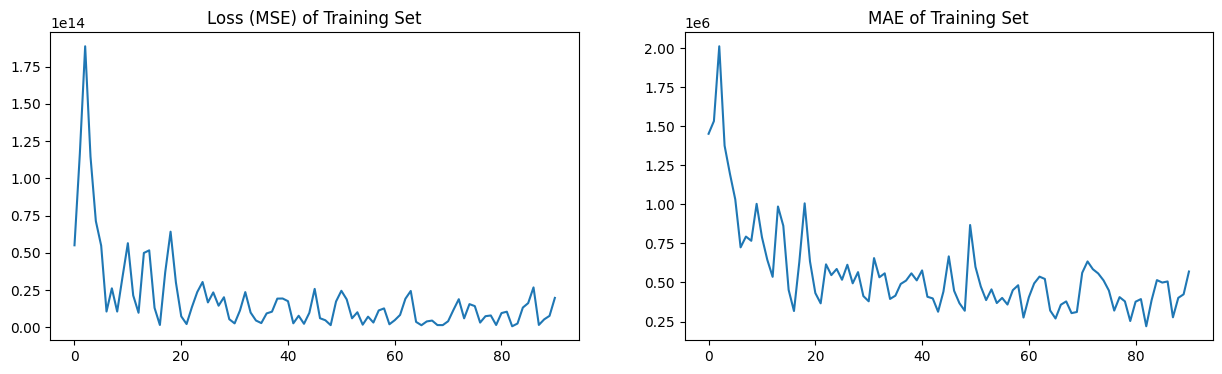

In [ ]:
# RNN
model_save_path_rnn = os.path.join(project_path, 'model/search_volume/mean/rnn')
plotTrainingHistory(model_save_path_rnn, '2022-12', 'model')

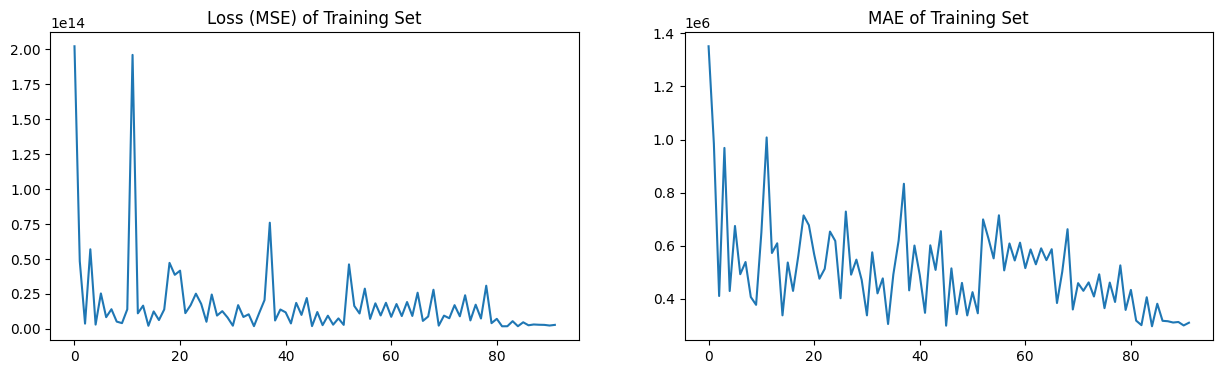

In [ ]:
# LSTM
model_save_path_lstm = os.path.join(project_path, 'model/search_volume/mean/lstm')
plotTrainingHistory(model_save_path_lstm, '2022-12', 'model')

## **7. Predicting Results**

y_train = y_test 往前 12 個月

<br>

||訓練資料X|訓練資料y|測試資料X|測試資料y|
|---|---|---|---|---|
|Start|2013-01 - 2016-12|2017-01|2014-01 - 2017-12|**2018-01**|
|End|2017-12 - 2021-11|2021-12|2018-12 - 2022-11|**2022-12**|


In [ ]:
file_category = 'search_volume'
search_volume_type = 'mean'

# 預測年月
start_y = 2018
start_m = 1
end_y = 2022
end_m = 12

### **7.1 Output Functions**

In [ ]:
# Output data path
output_data_path = '/content/gdrive/Shareddrives/Me/論文/Results'

In [ ]:
# Output
def outputPredictingResults(category: str, modelName: str, pred: dict, searchType: str):
    pred['org']['org'].to_excel(os.path.join(output_data_path, f'{category}/{searchType}/org_pred_{modelName}_{category}_{searchType}.xlsx'))
    pred['org']['dec'].to_excel(os.path.join(output_data_path, f'{category}/{searchType}/dec_pred_{modelName}_{category}_{searchType}.xlsx'))
    pred['org']['season'].to_excel(os.path.join(output_data_path, f'{category}/{searchType}/season_pred_{modelName}_{category}_{searchType}.xlsx'))
    pred['def']['org'].to_excel(os.path.join(output_data_path, f'{category}/{searchType}/def_pred_{modelName}_{category}_{searchType}.xlsx'))
    pred['def']['dec'].to_excel(os.path.join(output_data_path, f'{category}/{searchType}/dec_def_pred_{modelName}_{category}_{searchType}.xlsx'))
    pred['def']['season'].to_excel(os.path.join(output_data_path, f'{category}/{searchType}/season_def_pred_{modelName}_{category}_{searchType}.xlsx'))

def outputScores(category: str, modelName: str, scoresD: pd.DataFrame, searchType: str):
    scoresD.to_excel(os.path.join(output_data_path, f'{category}/{searchType}/scores_{modelName}_{category}_{searchType}.xlsx'))

### **7.2 RNN**

In [ ]:
# Load trained model
model_save_path_rnn = os.path.join(project_path, f'model/{file_category}/{search_volume_type}/rnn')

In [ ]:
# RNN (10 min.)
pred_rnn, scores_rnn = predictMonthlyRevenueNN(org_data, start_y, start_m, end_y, end_m, 'rnn', model_save_path_rnn, search_volume_data = search_volume_data)

Using time: 430.163  secs.


In [ ]:
# Output
outputPredictingResults(file_category, 'rnn', pred_rnn, search_volume_type)
outputScores(file_category, 'rnn', scores_rnn, search_volume_type)

#### **7.2.1 Predicting Results**

In [ ]:
# Original
print(pred_rnn['org']['org'].shape)
print(pred_rnn['org']['dec'].shape)
print(pred_rnn['org']['season'].shape)
pred_rnn['org']['org'].head(4)

(1240, 60)
(1240, 60)
(1240, 60)


2018-01    2018-02    2018-03    2018-04    2018-05    2018-06  \
1101 台泥  7378543.0  7354209.0  8694356.0  7973408.0  7881548.0  8982191.0   
1102 亞泥  4664265.0  5034922.0  5684320.0  5185901.0  5415800.0  5770604.0   
1103 嘉泥   143430.0   143913.0   268858.0   162596.0   133692.0   175649.0   
1104 環泥   363437.0   311420.0   464783.0   336982.0   330787.0   312582.0   

           2018-07    2018-08     2018-09     2018-10  ...    2022-03  \
1101 台泥  9132120.0  9588651.0  10462967.0  10098656.0  ...  8921412.0   
1102 亞泥  6044964.0  6450923.0   6977437.0   6721376.0  ...  7730338.0   
1103 嘉泥   146647.0   160665.0    253738.0     53808.0  ...   178068.0   
1104 環泥   340422.0   379132.0    427960.0    243869.0  ...   533822.0   

           2022-04    2022-05    2022-06    2022-07    2022-08     2022-09  \
1101 台泥  9292351.0  8863154.0  8835711.0  8736250.0  8688939.0  10047104.0   
1102 亞泥  7620068.0  7802619.0  8209126.0  8144692.0  8062980.0   8902258.0   
1103 嘉泥   195245.0   208324.0   185999.0   172211.0    82276.0    159930.0   
1104 環泥   560626.0   575599.0   591849.0   570895.0   576192.0    557462.0   

            2022-10     2022-11     2022-12  
1101 台泥  10348431.0  10977631.0  11745274.0  
1102 亞泥   8062560.0   8749822.0   8587160.0  
1103 嘉泥    109464.0    214514.0    186912.0  
1104 環泥    565900.0    479126.0    626335.0  

[4 rows x 60 columns]

In [ ]:
# Deflating
print(pred_rnn['def']['org'].shape)
print(pred_rnn['def']['dec'].shape)
print(pred_rnn['def']['season'].shape)
pred_rnn['def']['org'].head(4)

(1240, 60)
(1240, 60)
(1240, 60)


2018-01    2018-02    2018-03    2018-04     2018-05     2018-06  \
1101 台泥  7410642.0  7067122.0  8802952.0  8603772.0  10036734.0  10935624.0   
1102 亞泥  5049685.0  4564102.0  6149984.0  5650398.0   6468112.0   6939804.0   
1103 嘉泥   160849.0   104521.0   145088.0   174129.0    143969.0    165279.0   
1104 環泥   347280.0   332184.0   382266.0   379946.0    368000.0    416312.0   

            2018-07     2018-08     2018-09     2018-10  ...    2022-03  \
1101 台泥  10370666.0  11373794.0  10929752.0  10026614.0  ...  9261844.0   
1102 亞泥   7499791.0   7961090.0   7389093.0   6781917.0  ...  8580305.0   
1103 嘉泥    175503.0    164624.0    194648.0    185008.0  ...   173122.0   
1104 環泥    369987.0    373125.0    380809.0    377663.0  ...   535420.0   

           2022-04    2022-05    2022-06    2022-07    2022-08    2022-09  \
1101 台泥  9277566.0  8883267.0  9357321.0  7878741.0  8658151.0  9803011.0   
1102 亞泥  9147761.0  8246124.0  8348742.0  8340157.0  7659177.0  7221511.0   
1103 嘉泥   187793.0   180880.0   176243.0   170948.0   171479.0   186616.0   
1104 環泥   608697.0   553578.0   536475.0   555248.0   553768.0   595852.0   

            2022-10     2022-11     2022-12  
1101 台泥  10384997.0  11227243.0  12155996.0  
1102 亞泥   7660102.0   8480002.0   9402547.0  
1103 嘉泥    202294.0    215774.0    221977.0  
1104 環泥    583913.0    641099.0    663058.0  

[4 rows x 60 columns]

### **7.3 LSTM**


In [ ]:
# Load trained models
model_save_path_lstm = os.path.join(project_path, f'model/{file_category}/{search_volume_type}/lstm')

In [ ]:
# LSTM (13 min.)
pred_lstm, scores_lstm = predictMonthlyRevenueNN(org_data, start_y, start_m, end_y, end_m, 'lstm', model_save_path_lstm, search_volume_data = search_volume_data)

Using time: 608.835  secs.


In [ ]:
# Output
outputPredictingResults(file_category, 'lstm', pred_lstm, search_volume_type)
outputScores(file_category, 'lstm', scores_lstm, search_volume_type)

#### **7.3.1 Predicting Results**

In [ ]:
print(pred_lstm['org']['org'].shape)
print(pred_lstm['org']['dec'].shape)
print(pred_lstm['org']['season'].shape)
pred_lstm['org']['org'].head(4)

(1240, 60)
(1240, 60)
(1240, 60)


2018-01    2018-02    2018-03    2018-04    2018-05    2018-06  \
1101 台泥  8025613.0  7622504.0  8582700.0  8121254.0  8126611.0  8528679.0   
1102 亞泥  5257152.0  5101231.0  5154822.0  5423172.0  5556068.0  5780736.0   
1103 嘉泥   154246.0   130535.0   186256.0   206892.0   185164.0   190348.0   
1104 環泥   399897.0   352041.0   474450.0   371748.0   341055.0   361187.0   

           2018-07    2018-08     2018-09    2018-10  ...    2022-03  \
1101 台泥  9227522.0  9788265.0  10395981.0  9945337.0  ...  9545247.0   
1102 亞泥  6205094.0  6549440.0   6972948.0  6534480.0  ...  7961172.0   
1103 嘉泥   134781.0   166269.0    160612.0   121789.0  ...   157185.0   
1104 環泥   450466.0   384151.0    472870.0   362793.0  ...   538282.0   

           2022-04    2022-05    2022-06    2022-07    2022-08     2022-09  \
1101 台泥  9990826.0  7658636.0  9197746.0  9814944.0  7834398.0  11144387.0   
1102 亞泥  8171495.0  7032686.0  8343972.0  7957753.0  6032888.0   9564102.0   
1103 嘉泥   190683.0   168836.0   138414.0   163454.0   167812.0    183940.0   
1104 環泥   562295.0   564884.0   596087.0   702129.0   264428.0    643653.0   

            2022-10     2022-11     2022-12  
1101 台泥  10642445.0  11258602.0  12037216.0  
1102 亞泥   8080136.0   8937286.0   8747412.0  
1103 嘉泥    195023.0    218143.0    272339.0  
1104 環泥    642168.0    658503.0    500879.0  

[4 rows x 60 columns]

In [ ]:
print(pred_lstm['def']['org'].shape)
print(pred_lstm['def']['dec'].shape)
print(pred_lstm['def']['season'].shape)
pred_lstm['def']['org'].head(4)

(1240, 60)
(1240, 60)
(1240, 60)


2018-01    2018-02    2018-03    2018-04    2018-05     2018-06  \
1101 台泥  7831546.0  7406357.0  8443625.0  8841714.0  9757327.0  10789090.0   
1102 亞泥  4887571.0  4803731.0  5799857.0  5842198.0  6242816.0   6754115.0   
1103 嘉泥   135590.0   104647.0   161185.0   143822.0   148680.0    174787.0   
1104 環泥   354795.0   343778.0   393333.0   376383.0   389981.0    406696.0   

           2018-07     2018-08     2018-09     2018-10  ...    2022-03  \
1101 台泥  9769356.0  10889440.0  10662658.0  10210731.0  ...  8970538.0   
1102 亞泥  7115208.0   7486573.0   7164973.0   6967646.0  ...  8213837.0   
1103 嘉泥   186143.0    137300.0    190035.0    195183.0  ...   173287.0   
1104 環泥   363165.0    374598.0    366760.0    387382.0  ...   554618.0   

           2022-04    2022-05    2022-06    2022-07    2022-08     2022-09  \
1101 台泥  8958355.0  8451572.0  8936432.0  8148541.0  9008251.0  10294466.0   
1102 亞泥  8312770.0  8069688.0  7992658.0  8310428.0  7620181.0   7309277.0   
1103 嘉泥   206843.0   179695.0   169329.0   171237.0   178014.0    192767.0   
1104 環泥   633479.0   572244.0   500517.0   583265.0   557047.0    596086.0   

            2022-10     2022-11     2022-12  
1101 台泥  10227997.0  11534832.0  12464027.0  
1102 亞泥   7449999.0   8597123.0   9642628.0  
1103 嘉泥    193069.0    217079.0    220822.0  
1104 環泥    584027.0    645752.0    663266.0  

[4 rows x 60 columns]

### **7.4 Scores**

In [ ]:
# RNN
scores_rnn

RMSE-org   MAE-org  MAE%-org  MAPE-org   RMSE-def   MAE-def  \
2018-01  1348062.0  279124.0    0.1433    0.5709  1171082.0  219317.0   
2018-02  1314057.0  238413.0    0.1600    0.3059  1001745.0  196113.0   
2018-03   953314.0  213438.0    0.1137    0.6555  1458206.0  201439.0   
2018-04   891106.0  207940.0    0.1159    0.3553  1077991.0  178726.0   
2018-05  1200225.0  219069.0    0.1157    0.3552   625534.0  152938.0   
2018-06  1553289.0  241269.0    0.1260    0.6526  1118095.0  177494.0   
2018-07  1363472.0  208104.0    0.1057    0.5291  1389472.0  174709.0   
2018-08  1123746.0  183949.0    0.0893    0.2871   664733.0  151093.0   
2018-09  3099636.0  318265.0    0.1425    0.6780  1853868.0  206273.0   
2018-10  1884429.0  303993.0    0.1328    0.6547  3950970.0  317937.0   
2018-11  1085567.0  313278.0    0.1393    1.3631  1732895.0  206529.0   
2018-12  3205136.0  425147.0    0.1976    0.9429  1366982.0  221215.0   
2019-01  1295270.0  281565.0    0.1441    0.8173  1505716.0  210379.0   
2019-02  1883119.0  256994.0    0.1793    1.1548  1550733.0  187179.0   
2019-03   902768.0  222798.0    0.1186    0.3569  1129137.0  160494.0   
2019-04   786935.0  196785.0    0.1068    1.5864   921409.0  163790.0   
2019-05   748399.0  186181.0    0.0983    0.4565   703976.0  144249.0   
2019-06  1018560.0  245703.0    0.1297    1.0911   991068.0  167212.0   
2019-07  1072129.0  217000.0    0.1121    0.7172   421970.0  115823.0   
2019-08  1679718.0  275207.0    0.1393    2.2690   801287.0  150295.0   
2019-09  1097565.0  229535.0    0.1041    0.8468  4529515.0  280647.0   
2019-10  1833855.0  313254.0    0.1427    1.0869  1146386.0  169663.0   
2019-11  1354915.0  275440.0    0.1262    1.3231  1395035.0  188763.0   
2019-12  2512761.0  274321.0    0.1296    2.0584  1175126.0  185477.0   
2020-01  2639751.0  392294.0    0.2284    0.4999  2859486.0  371924.0   
2020-02  2683446.0  340869.0    0.2511    1.4212  1262763.0  229039.0   
2020-03  1837202.0  303732.0    0.1668    1.1259  1477835.0  215221.0   
2020-04  1319009.0  276033.0    0.1532    3.6223  1129096.0  234203.0   
2020-05  1106678.0  218402.0    0.1198    1.9574   903441.0  186352.0   
2020-06  1464808.0  250282.0    0.1315    0.7293  1355124.0  218041.0   
2020-07  1094182.0  227607.0    0.1145    0.5809   842050.0  177687.0   
2020-08  1333613.0  258085.0    0.1280    0.8776   824936.0  173802.0   
2020-09  3297933.0  340002.0    0.1552    1.8746  1218690.0  232625.0   
2020-10  2349020.0  262507.0    0.1176    1.6654  4070876.0  270561.0   
2020-11  2228888.0  313941.0    0.1302    1.6874  3241075.0  274612.0   
2020-12  4673619.0  394920.0    0.1604    3.1473  1006193.0  204981.0   
2021-01  3766942.0  509911.0    0.2318    1.0126  2167997.0  408883.0   
2021-02  4700631.0  413958.0    0.2305    2.1988   962504.0  192180.0   
2021-03  1787121.0  431706.0    0.1917  109.5476  1635203.0  325361.0   
2021-04  2062689.0  339007.0    0.1520    1.2514  2002821.0  258928.0   
2021-05  1268650.0  319422.0    0.1450    2.7398   851409.0  204222.0   
2021-06  2124297.0  276195.0    0.1230    2.1336  1693019.0  210654.0   
2021-07  1605562.0  385771.0    0.1703    2.2365  1255190.0  221451.0   
2021-08  3404921.0  321146.0    0.1399    0.6435  1433318.0  214256.0   
2021-09  2055898.0  293054.0    0.1135    0.5101  3131444.0  368143.0   
2021-10  2499531.0  347081.0    0.1393    0.7232  1387504.0  222496.0   
2021-11  2078120.0  264345.0    0.0981    0.6221  1636765.0  264623.0   
2021-12  1221103.0  305168.0    0.1081    3.1641   751372.0  186872.0   
2022-01  2203396.0  378472.0    0.1542    3.8813  4547627.0  411323.0   
2022-02  2330133.0  287431.0    0.1345    4.4897  2160187.0  227867.0   
2022-03  1610848.0  255157.0    0.0967    1.1500   976778.0  197478.0   
2022-04  2272728.0  352274.0    0.1526    0.9975  2774236.0  405108.0   
2022-05  1544212.0  257673.0    0.1051    1.4547  1245229.0  210493.0   
2022-06  1776156.0  400333.0    0.1509    9.1303  1962671.0  301237.

In [ ]:
# LSTM
scores_lstm

RMSE-org   MAE-org  MAE%-org  MAPE-org   RMSE-def   MAE-def  \
2018-01  1420108.0  278181.0    0.1428    0.5137  1519854.0  242665.0   
2018-02  1065483.0  243819.0    0.1636    0.4913   923388.0  197984.0   
2018-03  1215485.0  246251.0    0.1312    0.3245  1355082.0  197844.0   
2018-04  1169036.0  220333.0    0.1228    0.5085   891751.0  159547.0   
2018-05  1576355.0  238789.0    0.1261    0.3268   619047.0  150622.0   
2018-06  1803677.0  246466.0    0.1287    0.2827  1055282.0  174275.0   
2018-07   955061.0  184493.0    0.0937    0.3421  1386609.0  172618.0   
2018-08  1013484.0  177779.0    0.0863    0.2531   693643.0  135229.0   
2018-09  2631954.0  300089.0    0.1344    0.3842  1962897.0  183835.0   
2018-10  2308851.0  278594.0    0.1217    0.3200  3317623.0  286648.0   
2018-11  1880204.0  272956.0    0.1214    0.4844  1084769.0  171147.0   
2018-12  3686253.0  466620.0    0.2169    0.4710  1047488.0  200761.0   
2019-01  1480315.0  243891.0    0.1248    0.4234  1092644.0  193518.0   
2019-02  2554775.0  289849.0    0.2022    0.4287   975101.0  185849.0   
2019-03   802602.0  184218.0    0.0981    0.2804   550579.0  135586.0   
2019-04  1004576.0  238104.0    0.1292    0.5875   731828.0  155383.0   
2019-05   704238.0  197255.0    0.1042    0.2819   584318.0  130967.0   
2019-06  1029092.0  236109.0    0.1246    0.3655   712763.0  147365.0   
2019-07  1448529.0  233078.0    0.1204    0.2800   685011.0  141647.0   
2019-08  1424747.0  240968.0    0.1220    0.2847   742163.0  149603.0   
2019-09  1220774.0  272739.0    0.1237    0.3088  4580103.0  272436.0   
2019-10  2265770.0  320645.0    0.1460    0.4068   754676.0  146594.0   
2019-11  1206831.0  275078.0    0.1260    0.3334  1045334.0  160568.0   
2019-12  1667255.0  270901.0    0.1280    0.4815  2176720.0  186508.0   
2020-01  2799537.0  391042.0    0.2276    0.4653  3031426.0  363851.0   
2020-02  2472825.0  326428.0    0.2405    0.7073  1625259.0  247126.0   
2020-03  1288177.0  249743.0    0.1372    0.5182  1552471.0  219425.0   
2020-04  1239942.0  259672.0    0.1441    0.7175  1130000.0  217018.0   
2020-05  1221319.0  238389.0    0.1307    1.0140   815131.0  169195.0   
2020-06  1559834.0  267321.0    0.1404    0.4189  1125165.0  189951.0   
2020-07  1261591.0  252071.0    0.1268    0.3517  1047648.0  180939.0   
2020-08  2354753.0  302658.0    0.1502    0.5444   862666.0  159719.0   
2020-09  1878394.0  362763.0    0.1656    0.6466  1005653.0  209157.0   
2020-10  1211037.0  258561.0    0.1158    0.9009  3506712.0  251363.0   
2020-11  2550044.0  416279.0    0.1727    0.4283  3739215.0  315743.0   
2020-12  5070417.0  409009.0    0.1661    0.9768  1251551.0  210041.0   
2021-01  3669337.0  485461.0    0.2207    0.7612  2087792.0  424646.0   
2021-02  2599604.0  306931.0    0.1709    1.1609  1110480.0  211420.0   
2021-03  1759326.0  289697.0    0.1286    1.8151  1034653.0  238687.0   
2021-04  2436180.0  363305.0    0.1629    0.3308  2317698.0  258323.0   
2021-05  1687738.0  366414.0    0.1663    0.8321   777529.0  190573.0   
2021-06  2162304.0  269155.0    0.1198    0.7798  1868681.0  221926.0   
2021-07  1792351.0  299481.0    0.1322    0.6257  2930289.0  294535.0   
2021-08  2455111.0  374096.0    0.1630    0.3466   851102.0  173035.0   
2021-09  2285181.0  380906.0    0.1475    0.6346  3572625.0  323863.0   
2021-10  2564388.0  503007.0    0.2018    0.4947   817438.0  174856.0   
2021-11  3179015.0  448033.0    0.1662    0.8193   986252.0  213505.0   
2021-12  3893157.0  486759.0    0.1725    0.4040  1744268.0  219646.0   
2022-01  2570160.0  453538.0    0.1848    0.6027  3956470.0  360203.0   
2022-02  1186744.0  252373.0    0.1181    0.7459  2292657.0  207557.0   
2022-03  1377562.0  245654.0    0.0931    0.2439   931333.0  208337.0   
2022-04  2360448.0  378161.0    0.1638    0.5752  2668057.0  431777.0   
2022-05  1595560.0  283825.0    0.1158    0.3219  1229362.0  201828.0   
2022-06  1808796.0  375707.0    0.1416    1.6242  1989593.0  284022.

In [ ]:
# Mean scores of RNN
scores_rnn.mean()

RMSE-org           2.094529e+06
MAE-org            3.100338e+05
MAE%-org           1.447033e-01
MAPE-org           3.281652e+00
RMSE-def           1.849950e+06
MAE-def            2.419860e+05
MAE%-def           1.121150e-01
MAPE-def           5.236917e-01
RMSE-dec           2.164619e+06
MAE-dec            3.225136e+05
MAE%-dec           1.506283e-01
MAPE-dec           2.182530e+00
RMSE-dec_def       1.795389e+06
MAE-dec_def        2.289704e+05
MAE%-dec_def       1.067383e-01
MAPE-dec_def       3.649583e-01
RMSE-season        2.441168e+06
MAE-season         3.773366e+05
MAE%-season        1.741500e-01
MAPE-season        3.438077e+00
RMSE-season_def    2.925304e+06
MAE-season_def     3.185876e+05
MAE%-season_def    1.494850e-01
MAPE-season_def    6.383383e-01
dtype: float64

In [ ]:
# Mean scores of LSTM
scores_lstm.mean()

RMSE-org           2.105795e+06
MAE-org            3.202334e+05
MAE%-org           1.483733e-01
MAPE-org           5.478033e-01
RMSE-def           1.817896e+06
MAE-def            2.325270e+05
MAE%-def           1.079733e-01
MAPE-def           3.551033e-01
RMSE-dec           2.184678e+06
MAE-dec            3.235542e+05
MAE%-dec           1.503667e-01
MAPE-dec           7.554100e-01
RMSE-dec_def       1.823719e+06
MAE-dec_def        2.299859e+05
MAE%-dec_def       1.075067e-01
MAPE-dec_def       4.170483e-01
RMSE-season        2.363218e+06
MAE-season         3.663277e+05
MAE%-season        1.700583e-01
MAPE-season        6.183500e-01
RMSE-season_def    2.908531e+06
MAE-season_def     3.114768e+05
MAE%-season_def    1.462633e-01
MAPE-season_def    5.130300e-01
dtype: float64

## **8. Plots**


### **8.0 Read Saved Results**
2023.06.11

In [ ]:
# # Output data path
# output_data_path = '/content/gdrive/Shareddrives/Me/論文/Results'
# file_category = 'search_volume'
# search_volume_type = 'mean'

# # 預測年月
# start_y = 2018
# start_m = 1
# end_y = 2022
# end_m = 12

In [ ]:
# def getPredictingResults(category: str, modelName: str, searchType: str):
#     pred = {'org': {'org': pd.read_excel(os.path.join(output_data_path, f'{category}/{searchType}/org_pred_{modelName}_{category}_{searchType}.xlsx'), index_col = 0),
#                     'dec': pd.read_excel(os.path.join(output_data_path, f'{category}/{searchType}/dec_pred_{modelName}_{category}_{searchType}.xlsx'), index_col = 0),
#                     'season': pd.read_excel(os.path.join(output_data_path, f'{category}/{searchType}/season_pred_{modelName}_{category}_{searchType}.xlsx'), index_col = 0)
#             },
#             'def': {'org': pd.read_excel(os.path.join(output_data_path, f'{category}/{searchType}/def_pred_{modelName}_{category}_{searchType}.xlsx'), index_col = 0),
#                     'dec': pd.read_excel(os.path.join(output_data_path, f'{category}/{searchType}/dec_def_pred_{modelName}_{category}_{searchType}.xlsx'), index_col = 0),
#                     'season': pd.read_excel(os.path.join(output_data_path, f'{category}/{searchType}/season_def_pred_{modelName}_{category}_{searchType}.xlsx'), index_col = 0)
#             }
#     }
#     return pred

# def getScores(category: str, modelName: str, searchType: str):
#     scoresD = pd.read_excel(os.path.join(output_data_path, f'{category}/{searchType}/scores_{modelName}_{category}_{searchType}.xlsx'), index_col = 0)
#     return scoresD

In [ ]:
# pred_rnn = getPredictingResults(file_category, 'rnn', search_volume_type)
# pred_lstm = getPredictingResults(file_category, 'lstm', search_volume_type)
# scores_rnn = getScores(file_category, 'rnn', search_volume_type)
# scores_lstm = getScores(file_category, 'lstm', search_volume_type)

### **8.1 Expected v.s. Predicted**

#### **8.1.1 All**

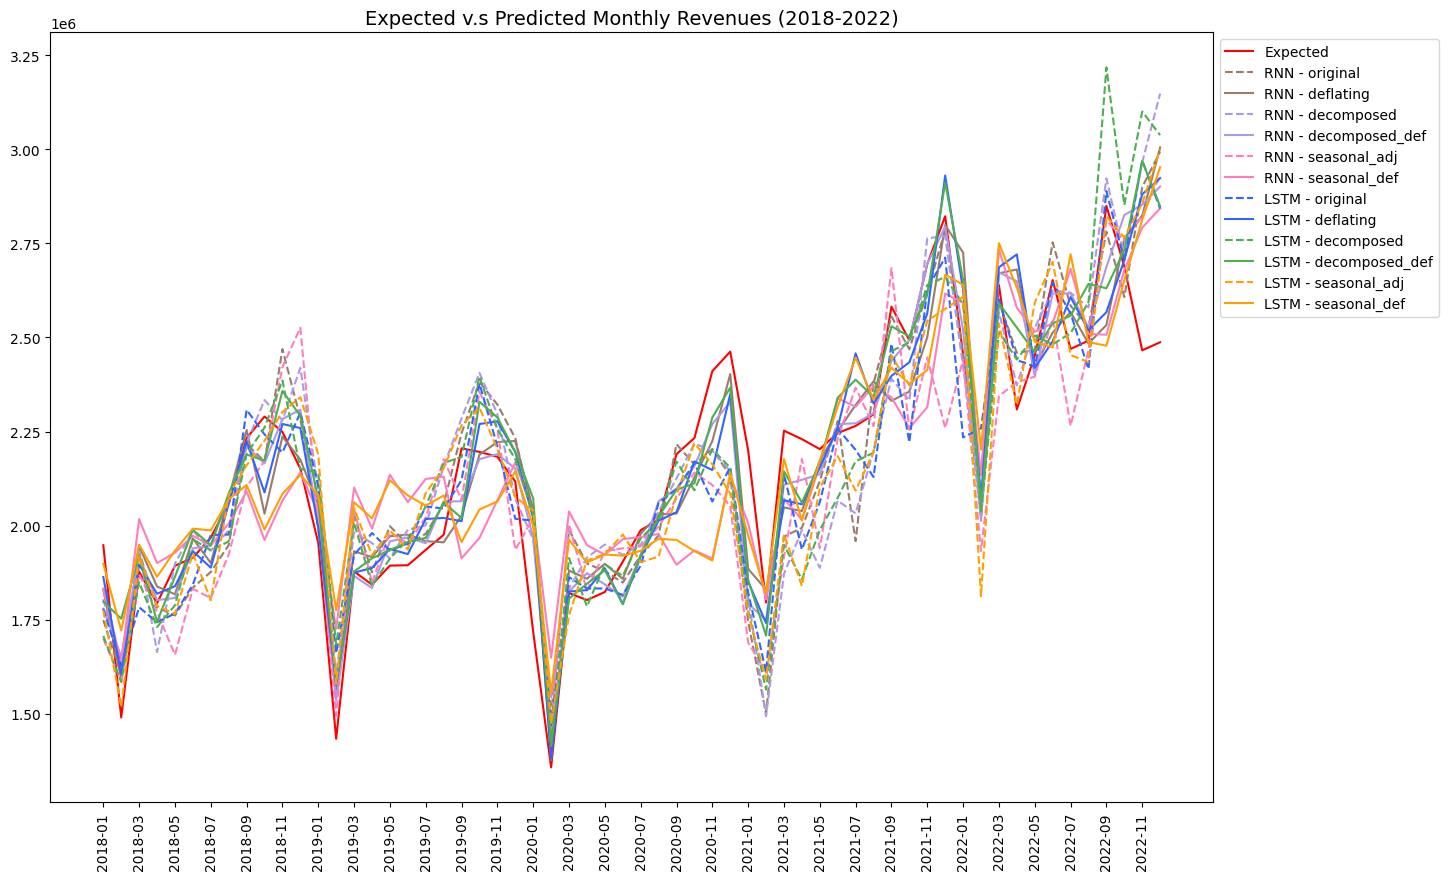

In [ ]:
plotExpectedPredictedRevenues(org_data, pred_rnn, pred_lstm, start_y, nn=True)

#### **8.1.2 分模型畫圖**

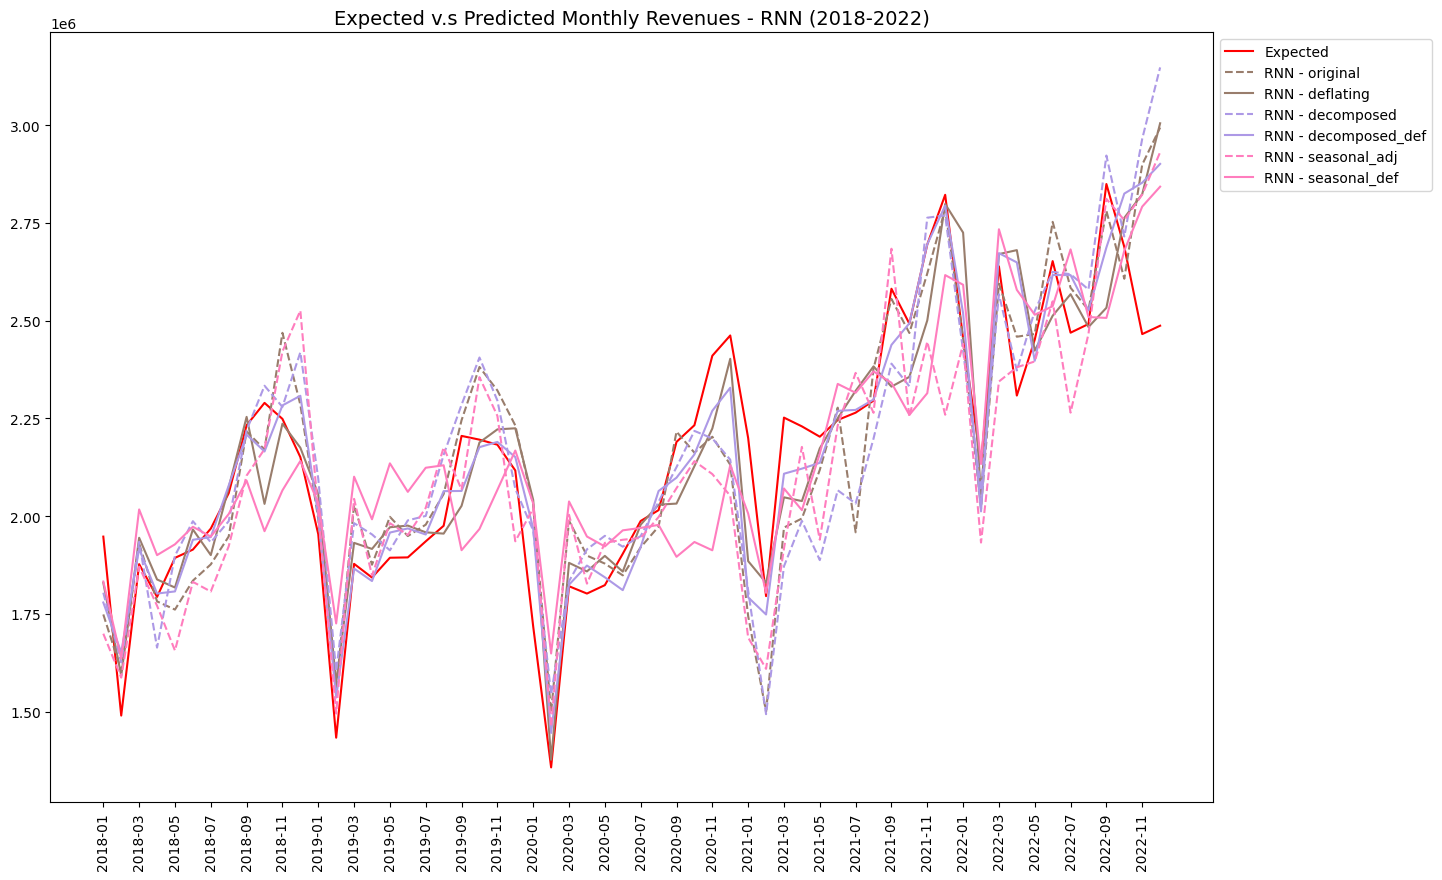

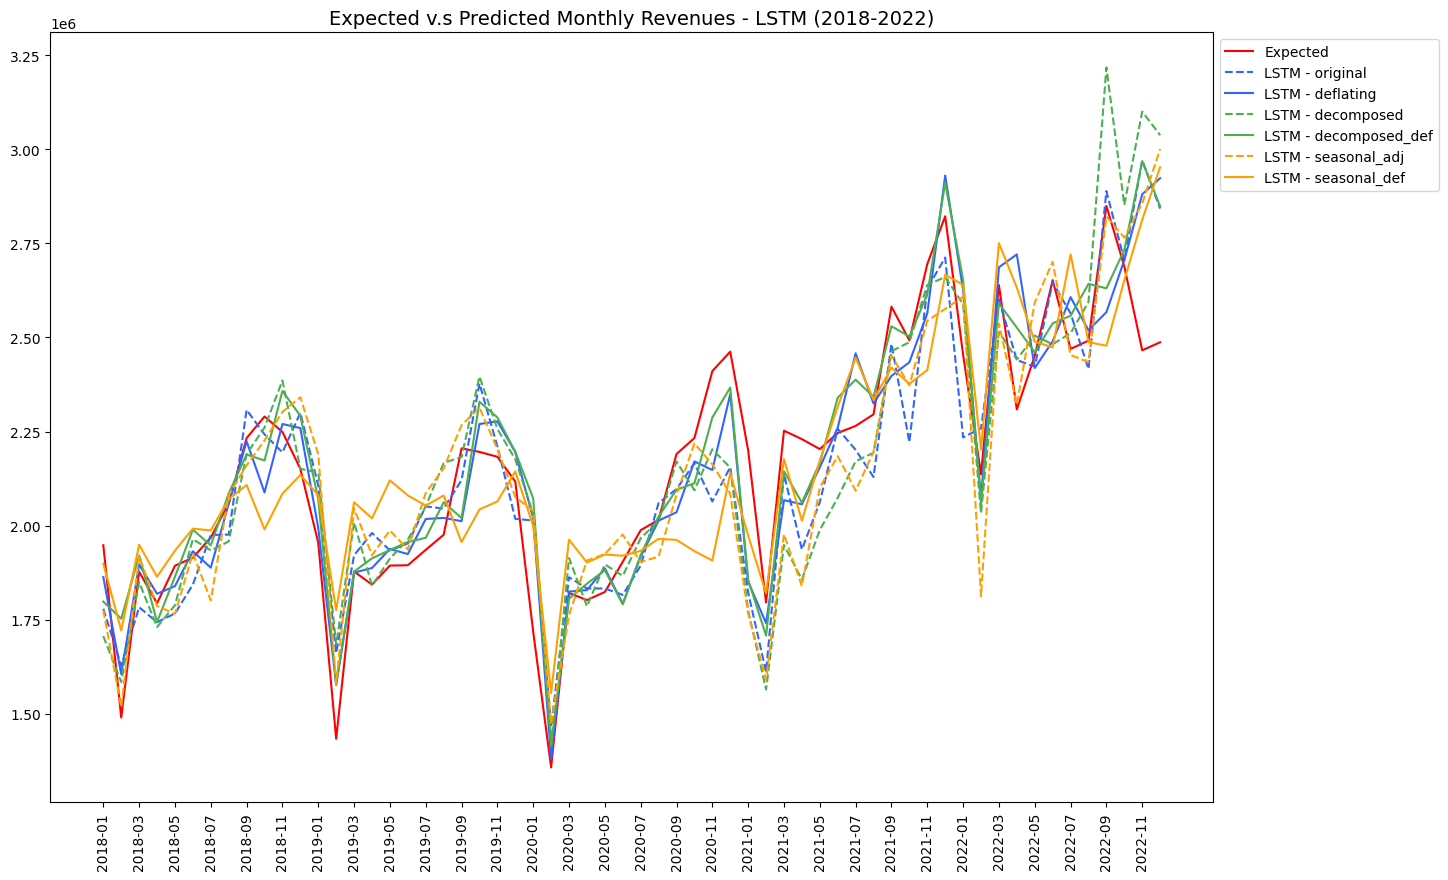

In [ ]:
plotModelExpectedPredictedRevenues(org_data, pred_rnn, 'rnn', start_y)
plotModelExpectedPredictedRevenues(org_data, pred_lstm, 'lstm', start_y)

### **8.2 Scores: RMSE, MAPE, MAE, MAE%**

*   RMSE (Root Mean Square Error)

  $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{y}_i - y_i)^2}$

<br>

*   MAE (Mean Absolute Error)

  $MAE = \frac{1}{n}\sum_{i=1}^n|\hat{y}_i - y_i|$

<br>

*   MAE% (MAE / mean of the sum of y_true)

  $MAE\% = \frac{\frac{1}{n}\sum_{i=1}^n|\hat{y}_i - y_i|}{\frac{1}{n}\sum_{i=1}^n y_i} = \frac{\sum_{i=1}^n|\hat{y}_i - y_i|}{\sum_{i=1}^n y_i}$

<br>

*   MAPE (Mean Absolute Percentage Error)

  $MAPE(\%) = \frac{1}{n}\sum_{i=1}^n \frac{|\hat{y}_i - y_i|}{y_i}$


#### **8.2.1 Plot All Scores**

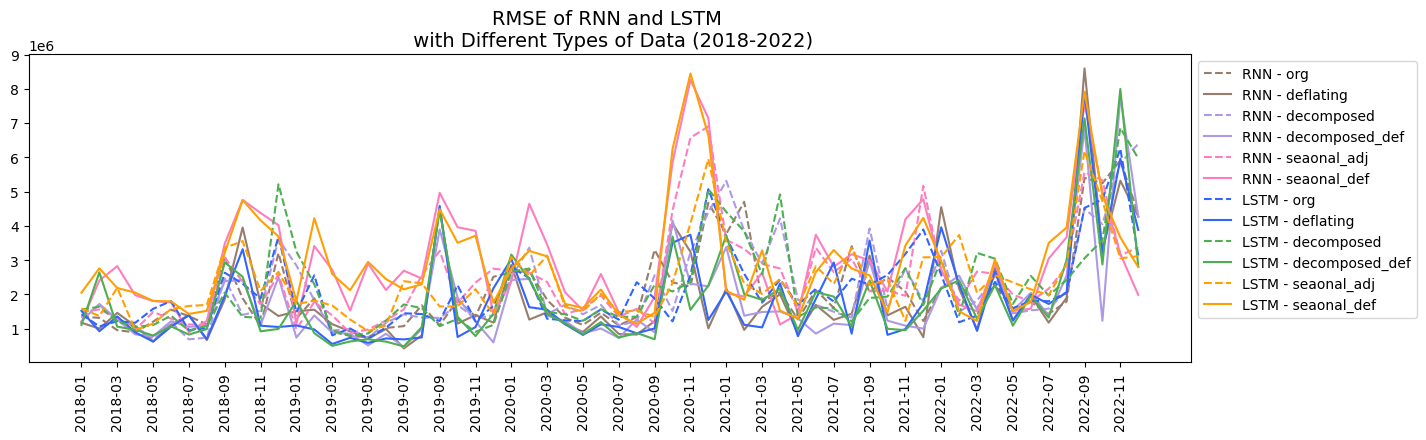

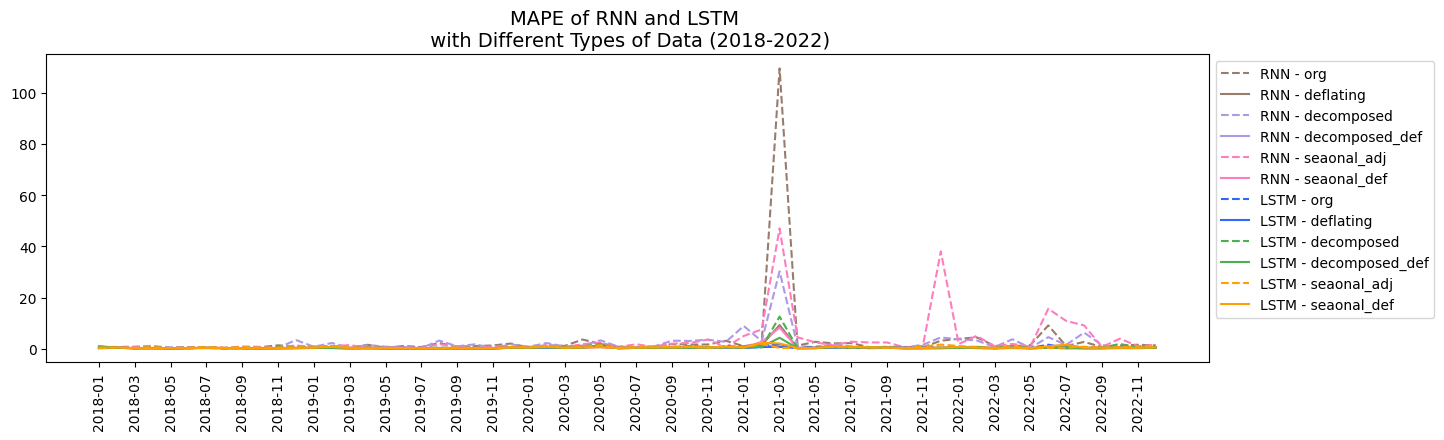

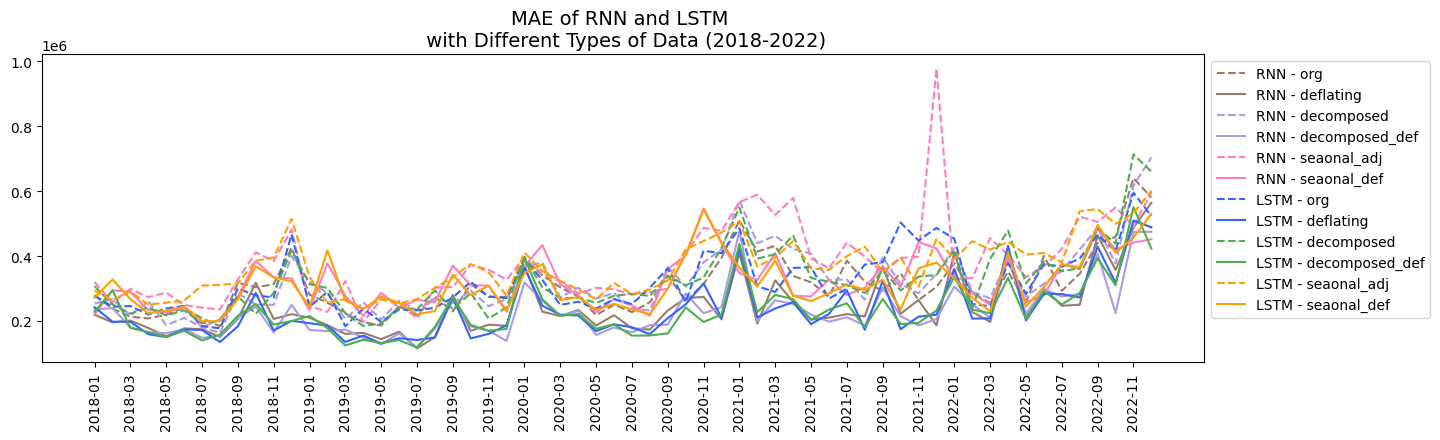

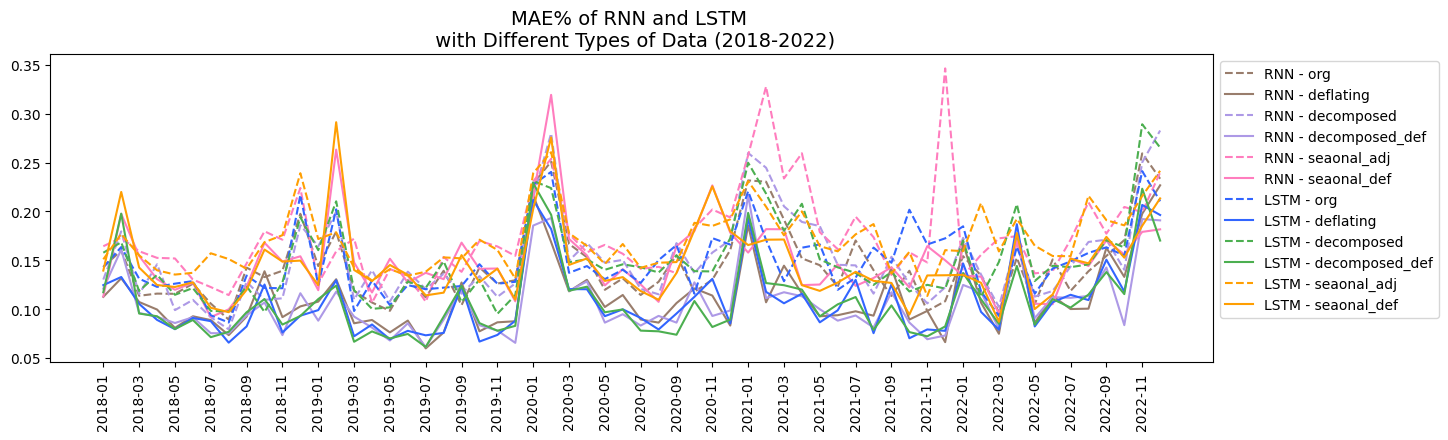

In [ ]:
plotAllScores(scores_rnn, scores_lstm, start_y, nn=True)

#### **8.2.2 分模型畫圖**

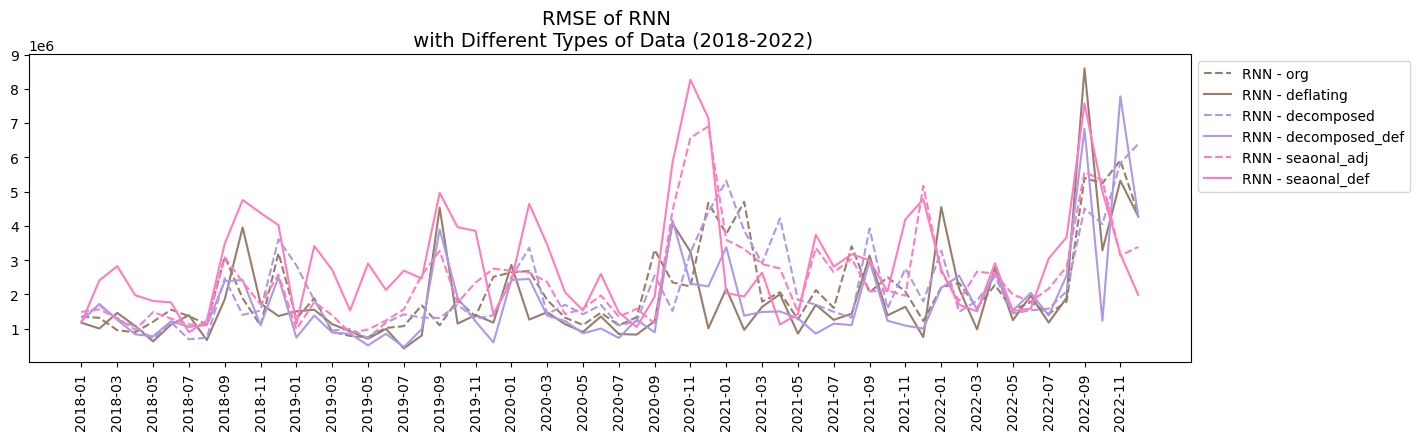

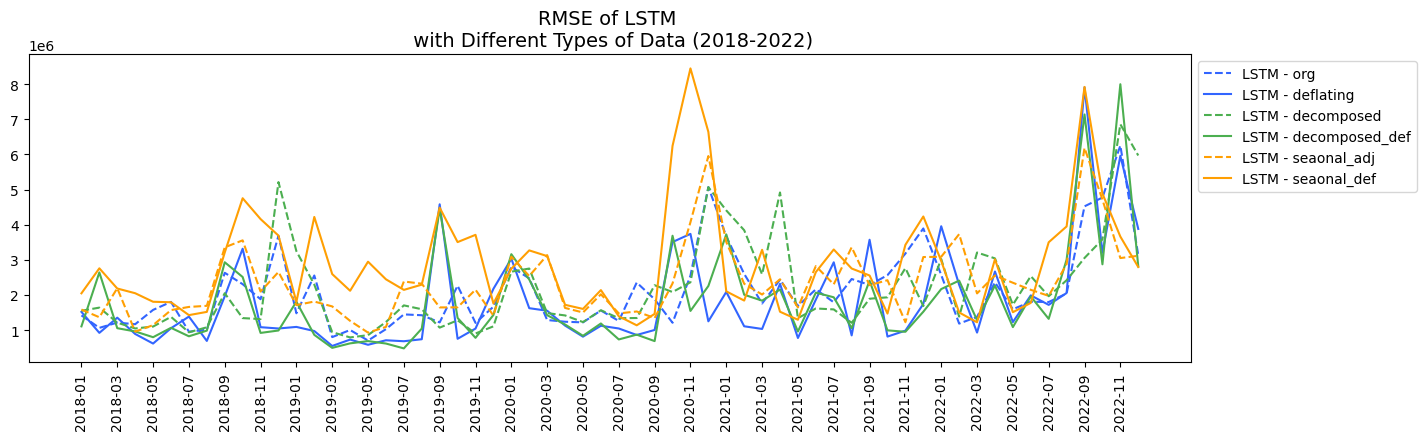

In [ ]:
# RMSE
compareModelScore(scores_rnn, scores_lstm, 'RMSE', start_y, nn=True)

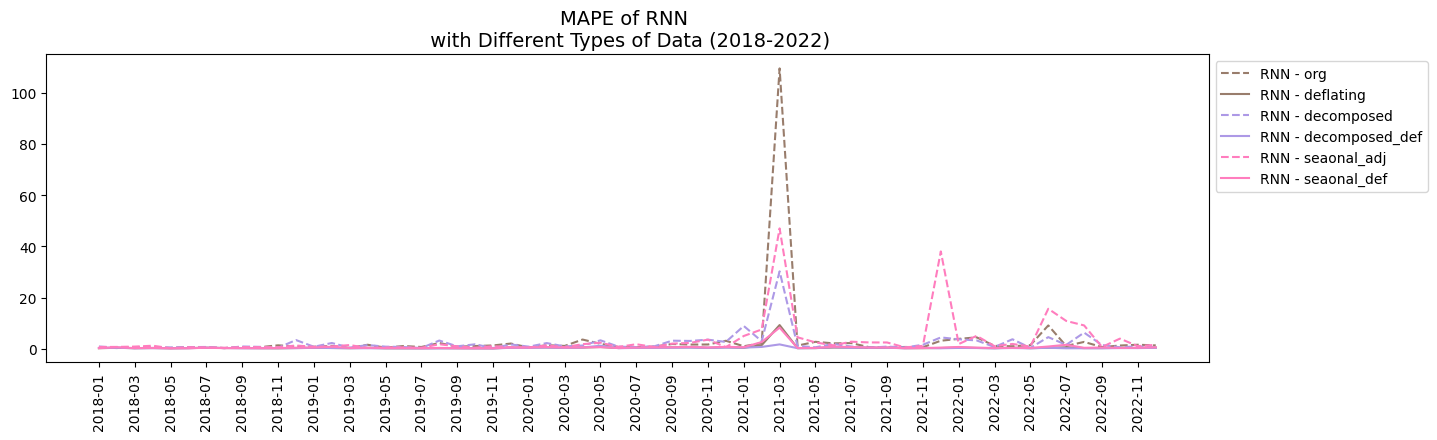

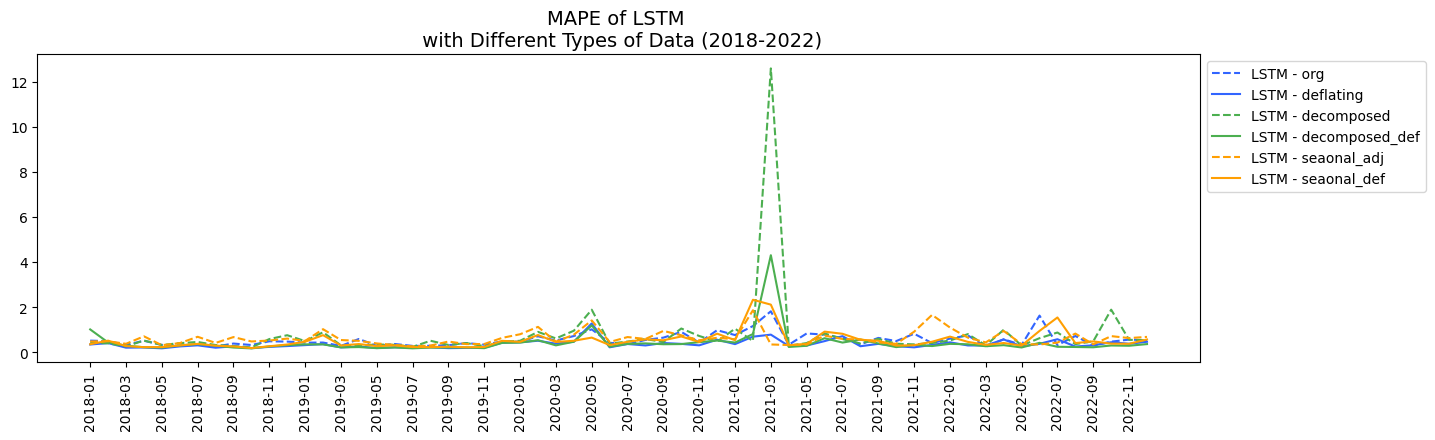

In [ ]:
# MAPE
compareModelScore(scores_rnn, scores_lstm, 'MAPE', start_y, nn=True)

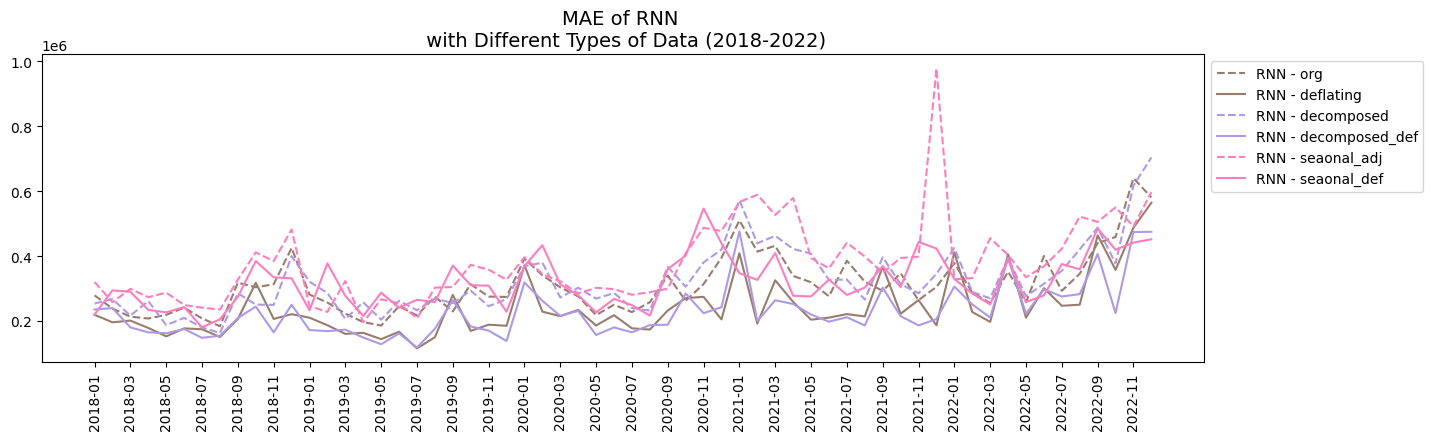

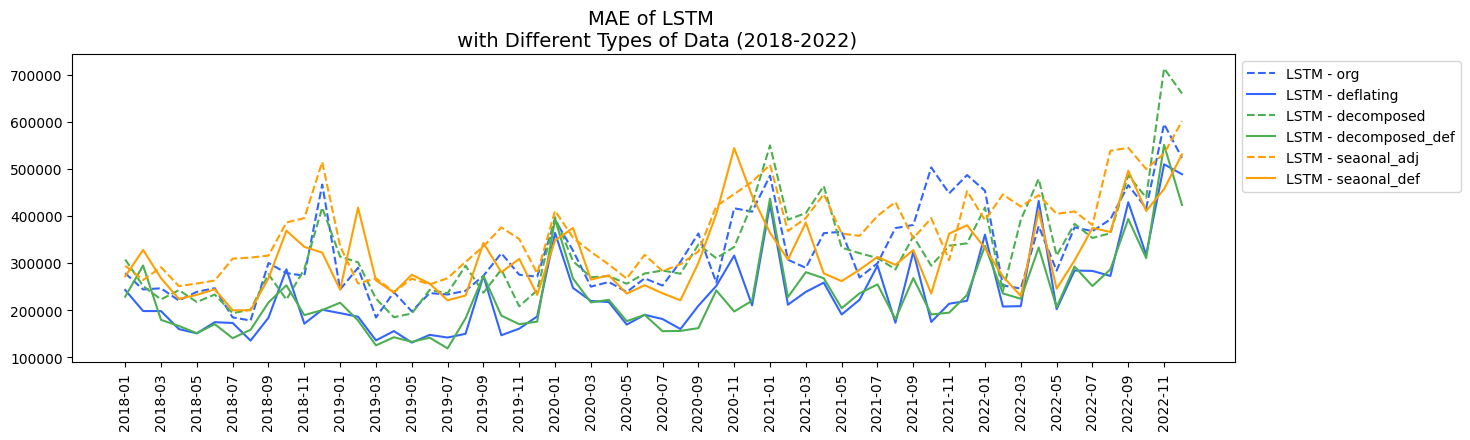

In [ ]:
# MAE
compareModelScore(scores_rnn, scores_lstm, 'MAE', start_y, nn=True)

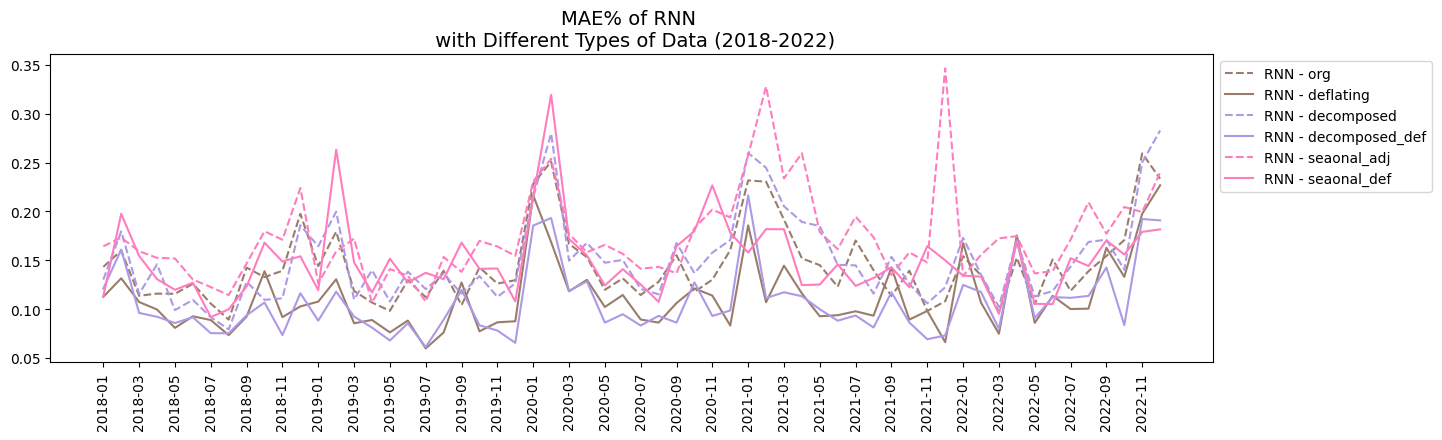

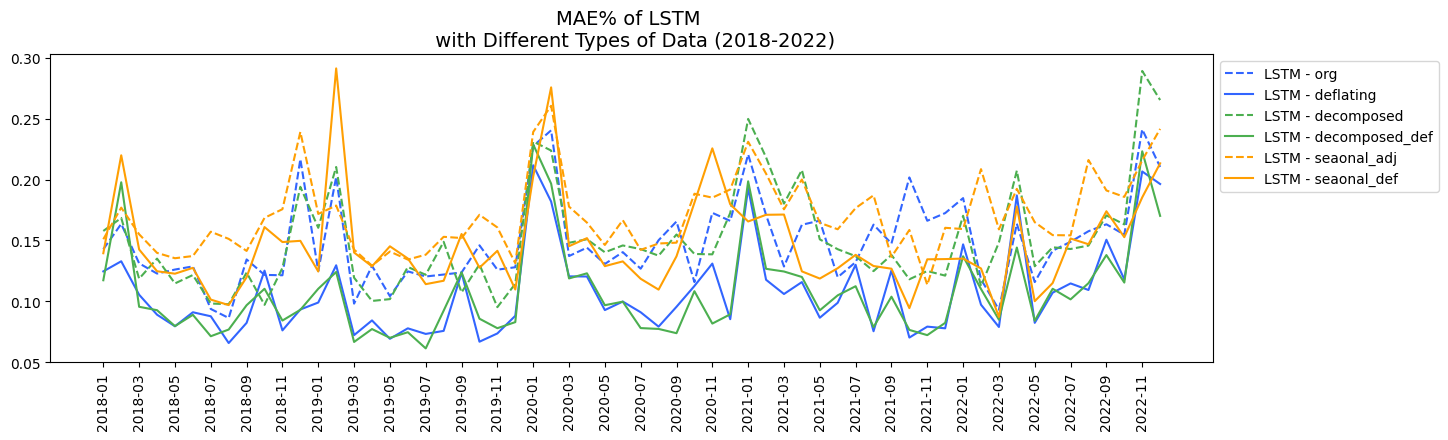

In [ ]:
# MAE%
compareModelScore(scores_rnn, scores_lstm, 'MAE%', start_y, nn=True)

#### **8.2.3 Boxplot**

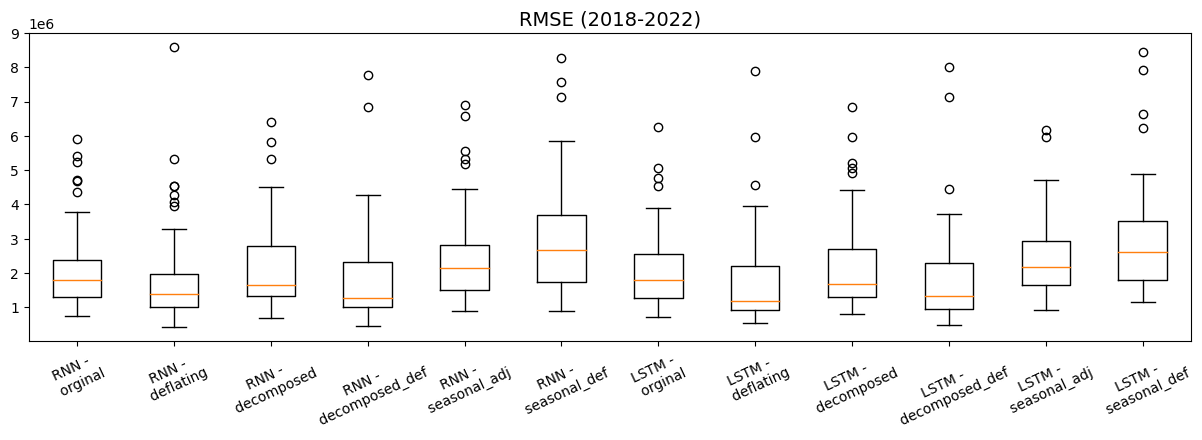

In [ ]:
# RMSE
scoreBoxplotV(scores_rnn, scores_lstm, 'RMSE', start_y, nn=True)

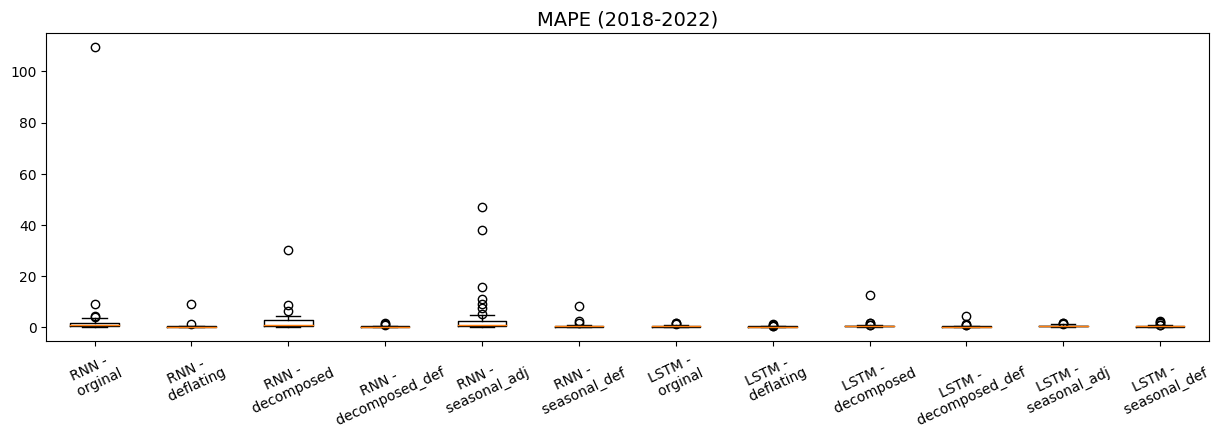

In [ ]:
# MAPE
scoreBoxplotV(scores_rnn, scores_lstm, 'MAPE', start_y, nn=True)

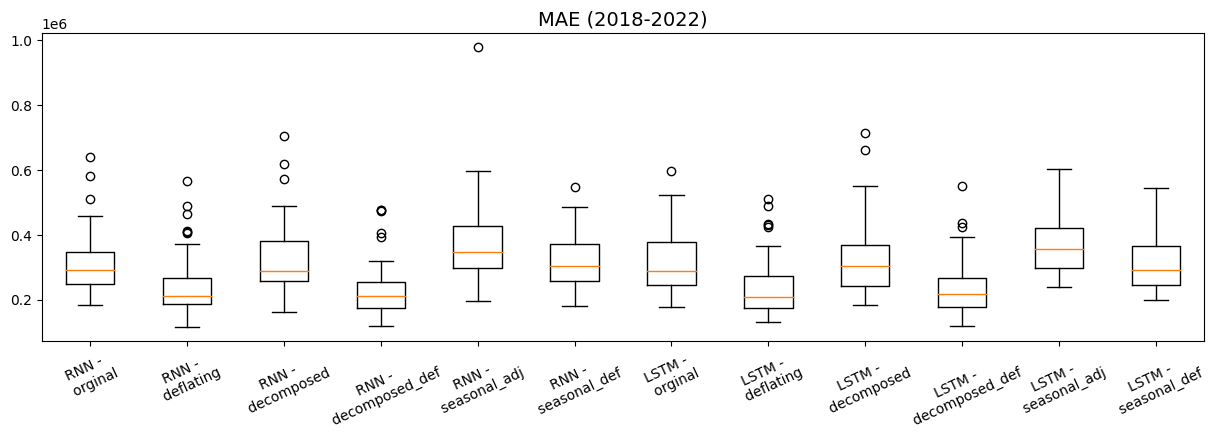

In [ ]:
# MAE
scoreBoxplotV(scores_rnn, scores_lstm, 'MAE', start_y, nn=True)

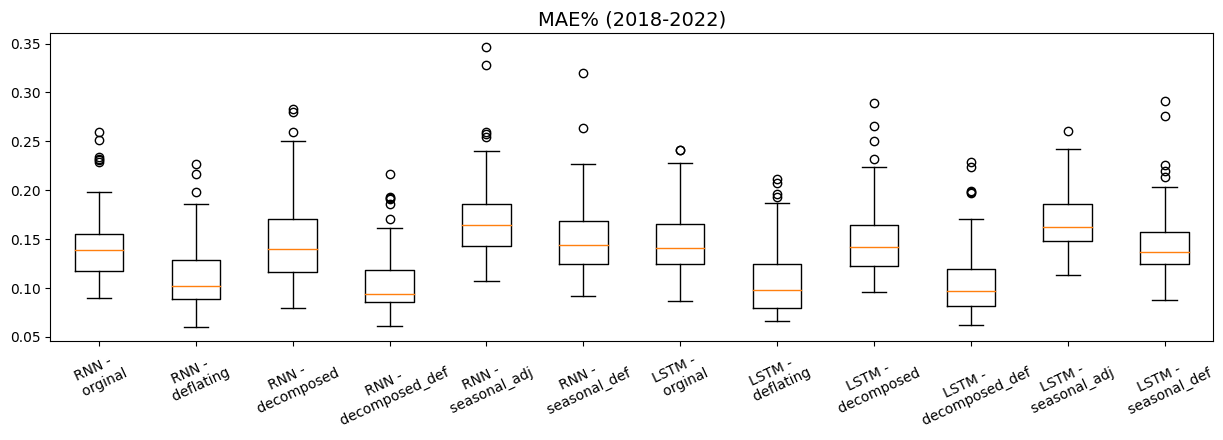

In [ ]:
# MAE%
scoreBoxplotV(scores_rnn, scores_lstm, 'MAE%', start_y, nn=True)

## **9. Best and Worst Model**

In [ ]:
bw = BestWorstModelNN(scores_rnn, scores_lstm)

### **9.1 各模型組合中，預測最好和最差的月份**

||modelType|dataType|scoreType|Best & Worst Month|Total|
|-|-|-|-|-|-|
|Numbers|2|6|4|2 (fixed)|2x6x4x2 = 96|

#### **9.1.1 RMSE**

In [ ]:
best_rmse, worst_rmse = bw.findBestWorstForAll('RMSE')

##### **最佳月份**

In [ ]:
best_rmse

modelName    dataType scoreType min_month  min_score
0        RNN         org      RMSE   2019-05   748399.0
4        RNN         def      RMSE   2019-07   421970.0
8        RNN         dec      RMSE   2018-07   686237.0
12       RNN     dec_def      RMSE   2019-07   459682.0
16       RNN      season      RMSE   2019-04   876329.0
20       RNN  season_def      RMSE   2018-07   893805.0
0       LSTM         org      RMSE   2019-05   704238.0
4       LSTM         def      RMSE   2019-03   550579.0
8       LSTM         dec      RMSE   2019-04   793415.0
12      LSTM     dec_def      RMSE   2019-07   481156.0
16      LSTM      season      RMSE   2019-05   930631.0
20      LSTM  season_def      RMSE   2020-08  1138270.0

##### **最差月份**

In [ ]:
worst_rmse

modelName    dataType scoreType max_month  max_score
0        RNN         org      RMSE   2022-11  5913377.0
4        RNN         def      RMSE   2022-09  8595748.0
8        RNN         dec      RMSE   2022-12  6391754.0
12       RNN     dec_def      RMSE   2022-11  7780218.0
16       RNN      season      RMSE   2020-12  6901997.0
20       RNN  season_def      RMSE   2020-11  8262137.0
0       LSTM         org      RMSE   2022-11  6250240.0
4       LSTM         def      RMSE   2022-09  7907266.0
8       LSTM         dec      RMSE   2022-11  6857227.0
12      LSTM     dec_def      RMSE   2022-11  7996175.0
16      LSTM      season      RMSE   2022-09  6183842.0
20      LSTM  season_def      RMSE   2020-11  8446408.0

#### **9.1.2 MAPE**

In [ ]:
best_mape, worst_mape = bw.findBestWorstForAll('MAPE')

##### **最佳月份**

In [ ]:
best_mape

modelName    dataType scoreType min_month  min_score
3        RNN         org      MAPE   2018-08     0.2871
7        RNN         def      MAPE   2019-11     0.1807
11       RNN         dec      MAPE   2018-08     0.2642
15       RNN     dec_def      MAPE   2019-11     0.1635
19       RNN      season      MAPE   2018-05     0.2438
23       RNN  season_def      MAPE   2018-05     0.2132
3       LSTM         org      MAPE   2022-03     0.2439
7       LSTM         def      MAPE   2018-05     0.1728
11      LSTM         dec      MAPE   2018-10     0.2123
15      LSTM     dec_def      MAPE   2018-10     0.1693
19      LSTM      season      MAPE   2019-07     0.2589
23      LSTM  season_def      MAPE   2018-10     0.1830

##### **最差月份**

In [ ]:
worst_mape

modelName    dataType scoreType max_month  max_score
3        RNN         org      MAPE   2021-03   109.5476
7        RNN         def      MAPE   2021-03     9.2829
11       RNN         dec      MAPE   2021-03    30.2663
15       RNN     dec_def      MAPE   2021-03     1.7276
19       RNN      season      MAPE   2021-03    47.0345
23       RNN  season_def      MAPE   2021-03     8.2753
3       LSTM         org      MAPE   2021-03     1.8151
7       LSTM         def      MAPE   2020-05     1.2774
11      LSTM         dec      MAPE   2021-03    12.5879
15      LSTM     dec_def      MAPE   2021-03     4.3032
19      LSTM      season      MAPE   2021-02     1.8612
23      LSTM  season_def      MAPE   2021-02     2.3260

#### **9.1.3 MAE**

In [ ]:
best_mae, worst_mae = bw.findBestWorstForAll('MAE')

##### **最佳月份**

In [ ]:
best_mae

modelName    dataType scoreType min_month  min_score
1        RNN         org       MAE   2018-08   183949.0
5        RNN         def       MAE   2019-07   115823.0
9        RNN         dec       MAE   2018-08   163288.0
13       RNN     dec_def       MAE   2019-07   118376.0
17       RNN      season       MAE   2019-04   196281.0
21       RNN  season_def       MAE   2018-07   180886.0
1       LSTM         org       MAE   2018-08   177779.0
5       LSTM         def       MAE   2019-05   130967.0
9       LSTM         dec       MAE   2019-04   184871.0
13      LSTM     dec_def       MAE   2019-07   118593.0
17      LSTM      season       MAE   2019-04   238349.0
21      LSTM  season_def       MAE   2018-07   199556.0

##### **最差月份**

In [ ]:
worst_mae

modelName    dataType scoreType max_month  max_score
1        RNN         org       MAE   2022-11   639786.0
5        RNN         def       MAE   2022-12   564203.0
9        RNN         dec       MAE   2022-12   703771.0
13       RNN     dec_def       MAE   2021-01   476349.0
17       RNN      season       MAE   2021-12   977873.0
21       RNN  season_def       MAE   2020-11   546412.0
1       LSTM         org       MAE   2022-11   595085.0
5       LSTM         def       MAE   2022-11   509616.0
9       LSTM         dec       MAE   2022-11   713358.0
13      LSTM     dec_def       MAE   2022-11   550713.0
17      LSTM      season       MAE   2022-12   601297.0
21      LSTM  season_def       MAE   2020-11   544048.0

#### **9.1.3 MAE%**

In [ ]:
best_mae_p, worst_mae_p = bw.findBestWorstForAll('MAE%')

##### **最佳月份**

In [ ]:
best_mae_p

modelName    dataType scoreType min_month  min_score
2        RNN         org      MAE%   2018-08     0.0893
6        RNN         def      MAE%   2019-07     0.0598
10       RNN         dec      MAE%   2018-08     0.0793
14       RNN     dec_def      MAE%   2019-07     0.0612
18       RNN      season      MAE%   2019-04     0.1065
22       RNN  season_def      MAE%   2018-07     0.0919
2       LSTM         org      MAE%   2018-08     0.0863
6       LSTM         def      MAE%   2018-08     0.0657
10      LSTM         dec      MAE%   2019-11     0.0952
14      LSTM     dec_def      MAE%   2019-07     0.0613
18      LSTM      season      MAE%   2021-11     0.1135
22      LSTM  season_def      MAE%   2022-03     0.0871

##### **最差月份**

In [ ]:
worst_mae_p

modelName    dataType scoreType max_month  max_score
2        RNN         org      MAE%   2022-11     0.2595
6        RNN         def      MAE%   2022-12     0.2268
10       RNN         dec      MAE%   2022-12     0.2829
14       RNN     dec_def      MAE%   2021-01     0.2165
18       RNN      season      MAE%   2021-12     0.3465
22       RNN  season_def      MAE%   2020-02     0.3194
2       LSTM         org      MAE%   2022-11     0.2413
6       LSTM         def      MAE%   2020-01     0.2118
10      LSTM         dec      MAE%   2022-11     0.2893
14      LSTM     dec_def      MAE%   2020-01     0.2289
18      LSTM      season      MAE%   2020-02     0.2607
22      LSTM  season_def      MAE%   2019-02     0.2914

### **9.2 RNN 和 LSTM 各自預測最好和最差的模型組合**

||modelType|dataType|scoreType|Best & Worst Month|Total|
|-|-|-|-|-|-|
|Numbers|2|1|4|2 (fixed)|2x1x4x2 = 16|

#### **9.2.1 RMSE**

##### **最佳模型**

In [ ]:
# RNN
bw.best_rnn['RMSE']

modelName dataType scoreType min_month  min_score
4       RNN      def      RMSE   2019-07   421970.0

In [ ]:
# LSTM
bw.best_lstm['RMSE']

modelName dataType scoreType min_month  min_score
12      LSTM  dec_def      RMSE   2019-07   481156.0

##### **最差模型**

In [ ]:
# RNN
bw.worst_rnn['RMSE']

modelName dataType scoreType max_month  max_score
4       RNN      def      RMSE   2022-09  8595748.0

In [ ]:
# LSTM
bw.worst_lstm['RMSE']

modelName    dataType scoreType max_month  max_score
20      LSTM  season_def      RMSE   2020-11  8446408.0

#### **9.2.2 MAPE**

##### **最佳模型**

In [ ]:
# RNN
bw.best_rnn['MAPE']

modelName dataType scoreType min_month  min_score
15       RNN  dec_def      MAPE   2019-11     0.1635

In [ ]:
# LSTM
bw.best_lstm['MAPE']

modelName dataType scoreType min_month  min_score
15      LSTM  dec_def      MAPE   2018-10     0.1693

##### **最差模型**

In [ ]:
# RNN
bw.worst_rnn['MAPE']

modelName dataType scoreType max_month  max_score
3       RNN      org      MAPE   2021-03   109.5476

In [ ]:
# LSTM
bw.worst_lstm['MAPE']

modelName dataType scoreType max_month  max_score
11      LSTM      dec      MAPE   2021-03    12.5879

#### **9.2.3 MAE**

##### **最佳模型**

In [ ]:
# RNN
bw.best_rnn['MAE']

modelName dataType scoreType min_month  min_score
5       RNN      def       MAE   2019-07   115823.0

In [ ]:
# LSTM
bw.best_lstm['MAE']

modelName dataType scoreType min_month  min_score
13      LSTM  dec_def       MAE   2019-07   118593.0

##### **最差模型**

In [ ]:
# RNN
bw.worst_rnn['MAE']

modelName dataType scoreType max_month  max_score
17       RNN   season       MAE   2021-12   977873.0

In [ ]:
# LSTM
bw.worst_lstm['MAE']

modelName dataType scoreType max_month  max_score
9      LSTM      dec       MAE   2022-11   713358.0

#### **9.2.4 MAE%**

##### **最佳模型**

In [ ]:
# RNN
bw.best_rnn['MAE%']

modelName dataType scoreType min_month  min_score
6       RNN      def      MAE%   2019-07     0.0598

In [ ]:
# LSTM
bw.best_lstm['MAE%']

modelName dataType scoreType min_month  min_score
14      LSTM  dec_def      MAE%   2019-07     0.0613

##### **最差模型**

In [ ]:
# RNN
bw.worst_rnn['MAE%']

modelName dataType scoreType max_month  max_score
18       RNN   season      MAE%   2021-12     0.3465

In [ ]:
# LSTM
bw.worst_lstm['MAE%']

modelName    dataType scoreType max_month  max_score
22      LSTM  season_def      MAE%   2019-02     0.2914

### **9.3 所有模型組合中，預測最好和最差的模型組合**

||modelType|dataType|scoreType|Best & Worst Month|Total|
|-|-|-|-|-|-|
|Numbers|1|1|4|2 (fixed)|1x1x4x2 = 8|


#### **9.3.1 RMSE**

##### **最佳模型**

In [ ]:
bw.best_all['RMSE']

modelName dataType scoreType min_month  min_score
4       RNN      def      RMSE   2019-07   421970.0

##### **最差模型**

In [ ]:
bw.worst_all['RMSE']

modelName dataType scoreType max_month  max_score
4       RNN      def      RMSE   2022-09  8595748.0

#### **9.3.2 MAPE**

##### **最佳模型**

In [ ]:
bw.best_all['MAPE']

modelName dataType scoreType min_month  min_score
15       RNN  dec_def      MAPE   2019-11     0.1635

##### **最差模型**

In [ ]:
bw.worst_all['MAPE']

modelName dataType scoreType max_month  max_score
3       RNN      org      MAPE   2021-03   109.5476

#### **9.3.3 MAE**

##### **最佳模型**

In [ ]:
bw.best_all['MAE']

modelName dataType scoreType min_month  min_score
5       RNN      def       MAE   2019-07   115823.0

##### **最差模型**

In [ ]:
bw.worst_all['MAE']

modelName dataType scoreType max_month  max_score
17       RNN   season       MAE   2021-12   977873.0

#### **9.3.4 MAE%**

##### **最佳模型**

In [ ]:
bw.best_all['MAE%']

modelName dataType scoreType min_month  min_score
6       RNN      def      MAE%   2019-07     0.0598

##### **最差模型**

In [ ]:
bw.worst_all['MAE%']

modelName dataType scoreType max_month  max_score
18       RNN   season      MAE%   2021-12     0.3465